# BERT Base - Augmented Data - All Data

In [ ]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
!pip install -q tensorflow==2.8.0

import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 668.3 MB 16 kB/s 
     |████████████████████████████████| 462 kB 5.1 MB/s 
     |████████████████████████████████| 1.4 MB 86.8 MB/s 
     |████████████████████████████████| 5.8 MB 60.2 MB/s 
2.8.0


In [ ]:
!pip install -q transformers==4.18.0

import transformers
print(transformers.__version__)

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 69.5 MB/s 
     |████████████████████████████████| 163 kB 74.0 MB/s 
     |████████████████████████████████| 880 kB 95.2 MB/s 
4.18.0


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
%cd /content/drive/MyDrive/Code/anantha

/content/drive/MyDrive/Code/anantha


In [ ]:
!ls

bert-fine-tuning.ipynb	dataset-awal  dataset-hasil-augmented


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None

# datasetPath = "/content/drive/MyDrive/Code/anantha"
dataset = pd.read_csv("dataset-awal/dataset.csv", index_col=0, encoding="utf-8")
dataset = dataset.rename({'Text': 'text', 'Emotion': 'emotion'}, axis=1)  # new method

In [ ]:
dataset = dataset[dataset.emotion != 'love']

In [ ]:
dataset.head()

,text,emotion
0,Thanks! I'm glad you got a kick out of it.,joy
1,I'm more surprised the dash cam was functionin...,surprise
3,when i learnt that my best friend had failed t...,anger
4,i feel as though that talking for a month is a...,joy
5,i feel like the addition of sweet fresh corn r...,joy


In [ ]:
dataset['emotion'].value_counts().sort_index()

anger       10793
disgust      5301
fear         5570
joy         14744
sadness     12555
surprise     6233
Name: emotion, dtype: int64

# Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dataset['emotion_encode'] = le.fit_transform(dataset['emotion'])
dataset.head()

,text,emotion,emotion_encode
0,Thanks! I'm glad you got a kick out of it.,joy,3
1,I'm more surprised the dash cam was functionin...,surprise,5
3,when i learnt that my best friend had failed t...,anger,0
4,i feel as though that talking for a month is a...,joy,3
5,i feel like the addition of sweet fresh corn r...,joy,3


In [ ]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_mapping)

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}


In [ ]:
LABEL_NAME = le.classes_
print(LABEL_NAME)

['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']


In [ ]:
emotion_col = dataset.pop("emotion")
emotion_col

0             joy
1        surprise
3           anger
4             joy
5             joy
           ...   
65022       anger
65024         joy
65025    surprise
65026       anger
65027       anger
Name: emotion, Length: 55196, dtype: object

In [ ]:
dataset

,text,emotion_encode
0,Thanks! I'm glad you got a kick out of it.,3
1,I'm more surprised the dash cam was functionin...,5
3,when i learnt that my best friend had failed t...,0
4,i feel as though that talking for a month is a...,3
5,i feel like the addition of sweet fresh corn r...,3
...,...,...
65022,I had smoothies in the past with these packets...,0
65024,I knew I'd see him here eventually. I really l...,3
65025,Nope what’s it about?,5
65026,Removed and warned. R1,0


# Train, Test, Validation Data Splitting

In [ ]:
import numpy as np

train_data, val_data, test_data = np.split(dataset.sample(frac=1), [int(.8*len(dataset)), int(.9*len(dataset))])

In [ ]:
train_data = train_data.reset_index().drop(['index'], axis=1)

In [ ]:
train_data['emotion_encode'].value_counts()

3    11820
4    10000
0     8675
5     4983
2     4464
1     4214
Name: emotion_encode, dtype: int64

In [ ]:
test_data = test_data.reset_index().drop(['index'], axis=1)

In [ ]:
test_data['emotion_encode'].value_counts()

3    1451
4    1280
0    1040
5     629
1     569
2     551
Name: emotion_encode, dtype: int64

In [ ]:
val_data = val_data.reset_index().drop(['index'], axis=1)

In [ ]:
val_data['emotion_encode'].value_counts()

3    1473
4    1275
0    1078
5     621
2     555
1     518
Name: emotion_encode, dtype: int64

In [ ]:
train_data.shape, test_data.shape, val_data.shape

((44156, 2), (5520, 2), (5520, 2))

# Model

In [ ]:
# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL = 'bert-base-uncased'

In [ ]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

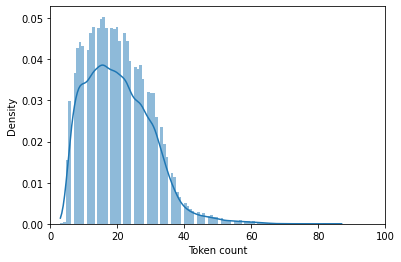

In [ ]:
'''
Ada banyak cara untuk menentukan max_length
Intuisinya adalah kita tidak ingin memotong kalimat, atau terlalu banyak menambahkan padding (komputasi lebih lama)
Contoh ini, max_lenght ditentukan dari distribusi token pada dataset
'''
token_lens = []

for txt in train_data.text:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [ ]:
# Dapat dilihat dari grafik diatas, sebagian besar kalimat tampaknya berisi kurang dari 80 token
# Maka, tentukan max_length adalah 80

MAX_LEN = 80

In [ ]:
# Buat fungsi untuk menggabungkan langkah tokenisasi, menambahkan special tokens untuk keseluruhan data sebagai input formatting ke model BERT
def convert_example_to_feature(sentence):
  return bert_tokenizer.encode_plus(
      sentence,
      add_special_tokens = True,
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN,
      return_attention_mask = True,
      return_token_type_ids=True
    )

In [ ]:
# Buat fungsi untuk memetakan input hasil input formatting agar sesuai dengan model BERT
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

In [ ]:
# Buat fungsi untuk iterasi pada setiap kalimat pada keseluruhan data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)

    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
# Tentukan nilai hyperparamter untuk fine-tuning
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

In [ ]:
# Lakukan input formatting menggunakan fungsi sebelumnya pada data keseluruhan data
train_encoded = encode(train_data).batch(BATCH_SIZE)
test_encoded = encode(test_data).batch(BATCH_SIZE)
val_encoded = encode(val_data).batch(BATCH_SIZE)

In [ ]:
'''
BERT untuk tugas klasifikasi sequence (teks) dengan menambahkan linear layer di atas pooled output untuk pengklasifikasi
https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertForSequenceClassification
'''

from transformers import TFBertForSequenceClassification

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=6)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tentukan optimizer dengan learning rate tertentu
# Paper aslinya menggunakan Adam Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
%%time
bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/5
1380/1380 [==============================] - 740s 520ms/step - loss: 0.9100 - accuracy: 0.6765 - val_loss: 0.6820 - val_accuracy: 0.7656
Epoch 2/5
1380/1380 [==============================] - 718s 520ms/step - loss: 0.6131 - accuracy: 0.7834 - val_loss: 0.6419 - val_accuracy: 0.7772
Epoch 3/5
1380/1380 [==============================] - 717s 520ms/step - loss: 0.5294 - accuracy: 0.8113 - val_loss: 0.6470 - val_accuracy: 0.7790
Epoch 4/5
1380/1380 [==============================] - 717s 519ms/step - loss: 0.4676 - accuracy: 0.8307 - val_loss: 0.6859 - val_accuracy: 0.7699
Epoch 5/5
1380/1380 [==============================] - 716s 519ms/step - loss: 0.4134 - accuracy: 0.8480 - val_loss: 0.7243 - val_accuracy: 0.7659
CPU times: user 39min 7s, sys: 6min 47s, total: 45min 55s
Wall time: 1h 33s


In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

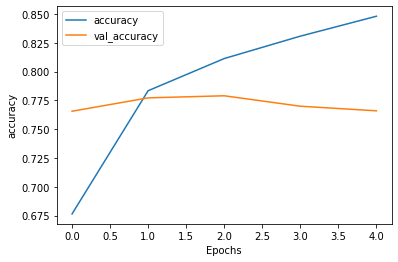

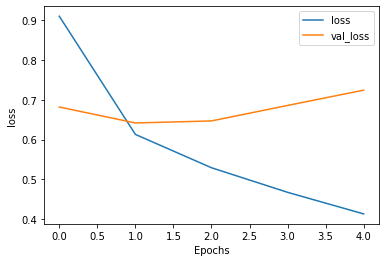

In [ ]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCHS):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, bert_history.history['accuracy'][i], bert_history.history['loss'][i], bert_history.history['val_accuracy'][i], bert_history.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.676488 	   0.910031 	   0.765580 	   0.681960
       2   0.783382 	   0.613143 	   0.777174 	   0.641859
       3   0.811283 	   0.529379 	   0.778986 	   0.647002
       4   0.830714 	   0.467637 	   0.769928 	   0.685886
       5   0.847993 	   0.413358 	   0.765942 	   0.724302


In [ ]:
out_model_path = 'hasil-fine-tuning'

bert_tokenizer.save_pretrained(f"{out_model_path}")
bert_model.save_pretrained(f"{out_model_path}")

In [ ]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

173/173 [==============================] - 31s 178ms/step - loss: 0.7390 - accuracy: 0.7578
Test Accuracy: 0.7577898502349854


In [ ]:
predicted_raw = bert_model.predict(test_encoded)

In [ ]:
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(test_data['emotion_encode'])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

accuracy_score(y_true, y_pred)

0.7577898550724638

In [ ]:
confusion_matrix(y_true, y_pred)

array([[ 805,   92,   24,   21,   62,   36],
       [ 192,  245,   45,   15,   46,   26],
       [  24,   26,  432,    9,   38,   22],
       [  37,   16,   17, 1267,   43,   71],
       [  83,   56,   53,   48, 1006,   34],
       [  58,   24,   29,   67,   23,  428]])

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      1040
           1       0.53      0.43      0.48       569
           2       0.72      0.78      0.75       551
           3       0.89      0.87      0.88      1451
           4       0.83      0.79      0.81      1280
           5       0.69      0.68      0.69       629

    accuracy                           0.76      5520
   macro avg       0.72      0.72      0.72      5520
weighted avg       0.76      0.76      0.76      5520



# Test

In [ ]:
def get_emotion(text):
  predict_input = bert_tokenizer.encode(
    text,
    max_length=MAX_LEN,
    truncation=True,
    padding=True,
    return_tensors="tf")

  tf_output = bert_model.predict(predict_input)[0]
  tf_prediction = tf.nn.softmax(tf_output, axis=1)
  label = tf.argmax(tf_prediction, axis=1)
  label = label.numpy()

  return LABEL_NAME[label[0]]

In [ ]:
anger_data = pd.read_csv('dataset-hasil-augmented/anger_noDup.csv', index_col=0)
anger_data = anger_data.reset_index(drop=True)
anger_data = anger_data.rename({'Text': 'text'}, axis=1)
anger_data = anger_data["text"].str[14:].replace("<","").replace(">","")
anger_data = anger_data.to_frame()

In [ ]:
%%time
anger_data["emotion"] = anger_data["text"].apply(get_emotion)

CPU times: user 3min 55s, sys: 15.1 s, total: 4min 10s
Wall time: 3min 32s


In [ ]:
anger_data

,text,emotion
0,"What the hell is it called? ""Livestreaming"" it...",anger
1,i am feeling a bit angry and angry and annoyed,anger
2,"[NAME], what in the actual fuck?",anger
3,I think that's where I might lose him lol,fear
4,This makes me want to die,disgust
...,...,...
3142,i feel like i ve been beaten up by the police ...,sadness
3143,i am feeling stressed because it does not look...,sadness
3144,ive been feeling pretty bitchy lately in general,anger
3145,"Fuck you no, it’s in your birthday. Birthday i...",anger


In [ ]:
anger_data.to_csv('anger_data.csv')